# NOT USED

## Checking radar line cross points

This was finding all points in a buffer around all points, to check for inconsistent depths. 

It was quite annoying to filter all the points down to one for each crossing, instead i used the process in 3_RADAR_bed_shape




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm

from shapely.geometry import Point, LineString, Polygon
import fiona

In [203]:
bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')

In [3]:
bed_gdf.head()

,CDP,x,y,DELAY,line_name,SEQnum,camp,geometry
0,100,-381564.6,-725999.7,8790,line7,1,KIS2,POINT (-381564.600 -725999.700)
1,101,-381563.4,-725998.3,8790,line7,1,KIS2,POINT (-381563.400 -725998.300)
2,102,-381561.6,-725996.1,8790,line7,1,KIS2,POINT (-381561.600 -725996.100)
3,103,-381559.5,-725993.6,8790,line7,1,KIS2,POINT (-381559.500 -725993.600)
4,104,-381557.4,-725991.1,8790,line7,1,KIS2,POINT (-381557.400 -725991.100)


# Looping over shapely intersections is too slow, so we use gdf.query

this give us a list of lists. For each point there is nan if no points are close or a list of CDPs of close points

In [204]:
#this finds all the points from other lines within a box of buffer_size around each point

other_points = []

buffer_size = 20.0

for i in tqdm(range(bed_gdf.shape[0])):

    other_points.append( bed_gdf.query(f'line_name != "{bed_gdf.line_name.loc[i]}" & camp == "{bed_gdf.camp.loc[i]}" & x > {bed_gdf.x.loc[i] - buffer_size} & x < {bed_gdf.x.loc[i] + buffer_size} & y > {bed_gdf.y.loc[i] - buffer_size} & y < {bed_gdf.y.loc[i] + buffer_size}').index.tolist() )    
    
#print(f'line_name != "{bed_gdf.line_name.loc[i]}" & camp == "{bed_gdf.camp.loc[i]}" & x > {bed_gdf.x.loc[i] - buffer_size} & x < {bed_gdf.x.loc[i] + buffer_size} & y > {bed_gdf.y.loc[i] - buffer_size} & y < {bed_gdf.y.loc[i] + buffer_size}')


In [205]:
#this converts the points which have no close points from [] to nan

op = []
for i, close_points in enumerate(other_points):
    if close_points==[]:
        op.append(np.nan)
    else:
        op.append([int(p) for p in close_points])

In [206]:
bed_gdf['close_points_20m'] = op

In [207]:
bed_gdf.dropna()

,CDP,x,y,DELAY,line_name,SEQnum,camp,geometry,close_points_20m
376,476,-380809.2,-725164.3,8620,line7,1,KIS2,POINT (-380809.200 -725164.300),"[30705, 30706]"
377,477,-380807.5,-725162.7,8620,line7,1,KIS2,POINT (-380807.500 -725162.700),"[30704, 30705, 30706, 30707]"
378,478,-380805.8,-725161.3,8620,line7,1,KIS2,POINT (-380805.800 -725161.300),"[30703, 30704, 30705, 30706, 30707, 30708]"
379,479,-380802.4,-725158.6,8620,line7,1,KIS2,POINT (-380802.400 -725158.600),"[30702, 30703, 30704, 30705, 30706, 30707, 307..."
380,480,-380800.7,-725157.1,8620,line7,1,KIS2,POINT (-380800.700 -725157.100),"[30701, 30702, 30703, 30704, 30705, 30706, 307..."
...,...,...,...,...,...,...,...,...,...
77697,964,-379157.2,-726682.4,7458,line5,49,KIS2,POINT (-379157.200 -726682.400),"[34398, 34399, 34400, 34401, 34402, 34403, 344..."
77698,965,-379159.4,-726684.9,7469,line5,49,KIS2,POINT (-379159.400 -726684.900),"[34399, 34400, 34401, 34402, 34403, 34404, 34405]"
77699,966,-379160.4,-726686.0,7480,line5,49,KIS2,POINT (-379160.400 -726686.000),"[34400, 34401, 34402, 34403, 34404]"
77700,967,-379162.6,-726688.6,7492,line5,49,KIS2,POINT (-379162.600 -726688.600),"[34400, 34401, 34402]"


In [208]:
bed_gdf.to_pickle('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/bed_gdf_close_points_20m.pkl')

# We now have the list of lists

1. Next we need to drop any close points that are consecutive.
2. Then...

In [209]:
bed_gdf = pd.read_pickle('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/bed_gdf_close_points_20m.pkl')

In [210]:
cp = bed_gdf.close_points_20m.tolist() #the list of close points

In [211]:
# this drops all the horizontally repeated points (ie for each 1 point it collects many close by points, this reduces it to 1 to 1)
# [55,56]          becomes [55]
# [55, 56, 57]             [56]

cp_horizontally_reduced = []

for i in tqdm(range(len(cp))):
# for i in tqdm(range(400)):

    if bed_gdf.close_points_20m.isna().loc[i]:
        cp_horizontally_reduced.append(np.nan)
        continue
    else:
        point = bed_gdf.close_points_20m.loc[i]
        split_at = np.argwhere(np.diff(np.array(point)) != 1 ).flatten() + 1
        list_of_points_sections = np.split(point, split_at)
        points_output = []
        for points_section in list_of_points_sections:
            points_output.append( int(np.median(points_section)) )
        cp_horizontally_reduced.append(points_output)

In [222]:
bed_gdf['close_points_20m'] = cp_horizontally_reduced

In [223]:
# this time making cps close points with no vertical double ups, and including the CDP from original point.
# [55]          becomes [55]
# [56]                  [90]
# [90]

prev_point = 0

cps_vertically_reduced = []

del cps

for i, row in bed_gdf.iterrows():
    
    if np.isnan(row.close_points_20m).any():
        cps = np.nan
        cps_vertically_reduced.append(cps)
        continue
    
    if prev_point == row.close_points_20m:
        cps = np.nan
              
    else:
        cps = [int(row.CDP)] + row.close_points_20m
    
    cps_vertically_reduced.append(cps)
    
    prev_point = row.close_points_20m  

In [224]:
bed_gdf['close_points_20m'] = cps_vertically_reduced

In [225]:
bed_gdf.to_pickle('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/bed_gdf_close_points_20m_filtered.pkl')

# Next we examine clusters of points and size of error in delay

In [228]:
cps_vertically_reduced

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [229]:
clusters = bed_gdf.close_points_20m.dropna().tolist()
#NB we are moving to no nans so different length different indicies

In [230]:
clusters

[[476, 30705],
 [484, 30706],
 [485, 30707],
 [486, 30706],
 [493, 30707],
 [497, 59424],
 [498, 59425],
 [502, 59426],
 [505, 59425],
 [506, 59424],
 [507, 59423],
 [508, 59422],
 [509, 59421],
 [511, 59420],
 [512, 59421],
 [513, 59422],
 [514, 59423],
 [515, 59424],
 [519, 33653],
 [521, 33654],
 [522, 33655],
 [524, 33656],
 [526, 33657],
 [527, 33656],
 [529, 33655],
 [531, 33654],
 [534, 33653],
 [1344, 70683],
 [100, 71439],
 [101, 71440],
 [102, 71439],
 [103, 71440],
 [106, 71439],
 [147, 71805],
 [149, 71804],
 [152, 71803],
 [154, 71804],
 [155, 71806],
 [157, 71807],
 [158, 71808],
 [160, 71807],
 [164, 71806],
 [1124, 60234],
 [1127, 60233],
 [1129, 60232],
 [1131, 60233],
 [1132, 60234],
 [1133, 60235],
 [1134, 60236],
 [1135, 60237],
 [1136, 60236],
 [1140, 60235],
 [1628, 76177],
 [1630, 76178],
 [1633, 76179],
 [1636, 76178],
 [1638, 76177],
 [803, 36629],
 [805, 36628],
 [807, 36627],
 [809, 36626],
 [810, 36625],
 [811, 36626],
 [813, 36627],
 [816, 36628],
 [817, 36

In [231]:
clusters_delay = []  #instead of showing the index show the delay

for cluster in clusters:
    cluster_delay = []
    for i in cluster:
        cluster_delay.append( int(bed_gdf.DELAY.loc[i] ))
    clusters_delay.append(np.array(cluster_delay))
    

In [232]:
clusters_range = []

for cluster in clusters_delay:
    clusters_range.append( cluster.max() - cluster.min()  )
    

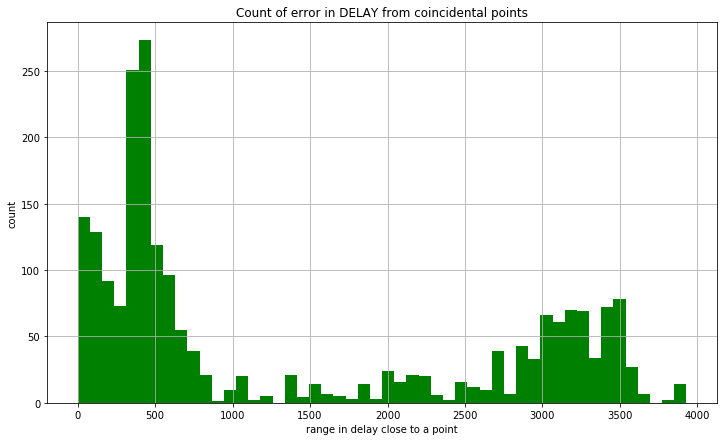

In [233]:
plt.figure(figsize=(12,7))
plt.hist(clusters_range, 50, density=False, facecolor='g')
plt.grid()
plt.title('Count of error in DELAY from coincidental points')
plt.xlabel('range in delay close to a point')
plt.ylabel('count')
plt.show()

In [234]:
threshold = 700
clusters_range = np.array(clusters_range)
error_indicies = np.argwhere(clusters_range > threshold).flatten()
noerror_indicies = np.argwhere(clusters_range <= threshold).flatten()

In [281]:
delay_errors_above_threshold_indicies = np.array(clusters)[error_indicies].tolist()
delay_noerrors_above_threshold_indicies = np.array(clusters)[noerror_indicies].tolist()

In [282]:
indicies_of_delay_error_points = list(set([y for x in delay_errors_above_threshold_indicies for y in x]))
indicies_of_delay_noerror_points = list(set([y for x in delay_noerrors_above_threshold_indicies for y in x]))

# Now plot the results

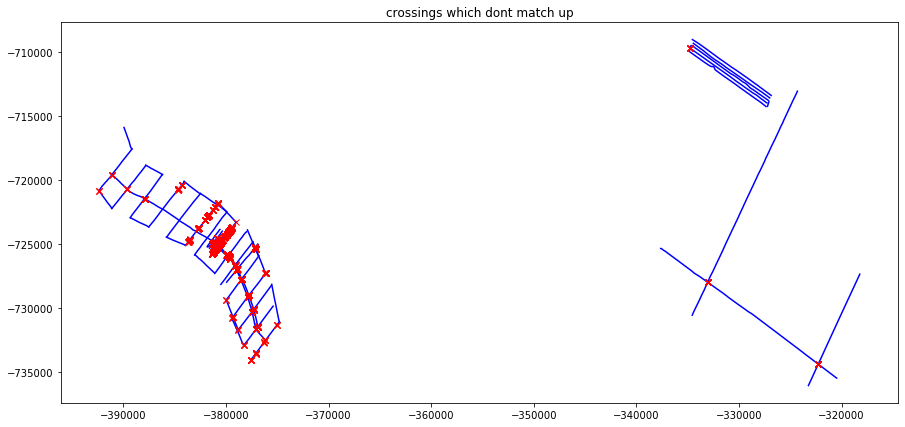

In [283]:
plt.figure(figsize=(15,7))
for line in bed_gdf.line_name.unique().tolist():
    plt.plot(bed_gdf[bed_gdf.line_name==line].x,bed_gdf[bed_gdf.line_name==line].y,'b-')
plt.plot(bed_gdf.x.loc[indicies_of_delay_error_points],bed_gdf.y.loc[indicies_of_delay_error_points],'rx')
plt.title('crossings which dont match up')
plt.show()


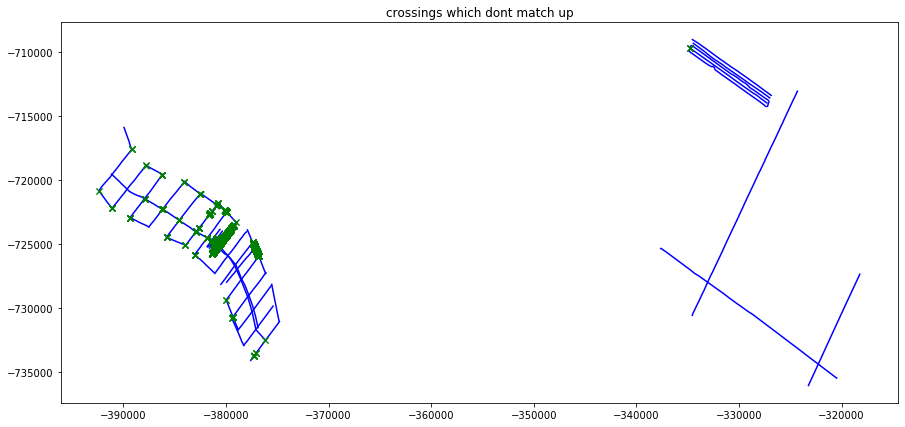

In [284]:
plt.figure(figsize=(15,7))
for line in bed_gdf.line_name.unique().tolist():
    plt.plot(bed_gdf[bed_gdf.line_name==line].x,bed_gdf[bed_gdf.line_name==line].y,'b-')
plt.plot(bed_gdf.x.loc[indicies_of_delay_noerror_points],bed_gdf.y.loc[indicies_of_delay_noerror_points],'gx')
plt.title('crossings which dont match up')
plt.show()


In [269]:
def plotgdf(gdf):

    plt.figure(figsize=(12,7))
    for line in gdf.line_name.unique().tolist():
        plt.plot(gdf[gdf.line_name==line].x,gdf[gdf.line_name==line].y,'b-')
    plt.plot(gdf.x.loc[indicies_of_delay_error_points],gdf.y.loc[indicies_of_delay_error_points],'rx')

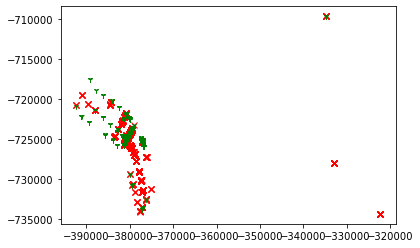

In [286]:
plt.plot(bed_gdf.x.loc[indicies_of_delay_error_points],bed_gdf.y.loc[indicies_of_delay_error_points],'rx')
plt.plot(bed_gdf.x.loc[indicies_of_delay_noerror_points],bed_gdf.y.loc[indicies_of_delay_noerror_points],'g1')

# ie a bit fooked

ValueError: x and y must have same first dimension, but have shapes (1255,) and (1522,)

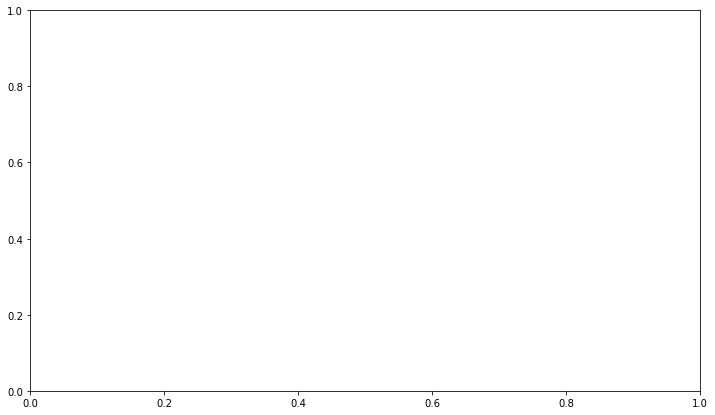

In [272]:
plt.figure(figsize=(12,7))
plt.plot(bed_gdf[bed_gdf.line_name=='line7'].x,bed_gdf[bed_gdf.line_name==line].y,'b-')
plt.plot(bed_gdf.x.loc[CDPs_of_delay_error_points],bed_gdf.y.loc[CDPs_of_delay_error_points],'rx')